In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##  Data Loading and Exploration

We begin by loading the medical insurance dataset and performing initial exploration to understand the structure, datatypes, and check for any missing values.


In [2]:
# Load dataset
data = pd.read_csv(r'C:\Users\kanad\PycharmProjects\FSM.ML.2\Main\Medical_Price_Dataset.csv')

# Data exploration
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())
print("\nDataset Information:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Shape: (1338, 7)

First 5 rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Summary Statistics:
        

## Data Visualization
Visualizing the distribution of charges and relationships with age, BMI, and smoking status helps identify patterns and outliers, which guide model development.


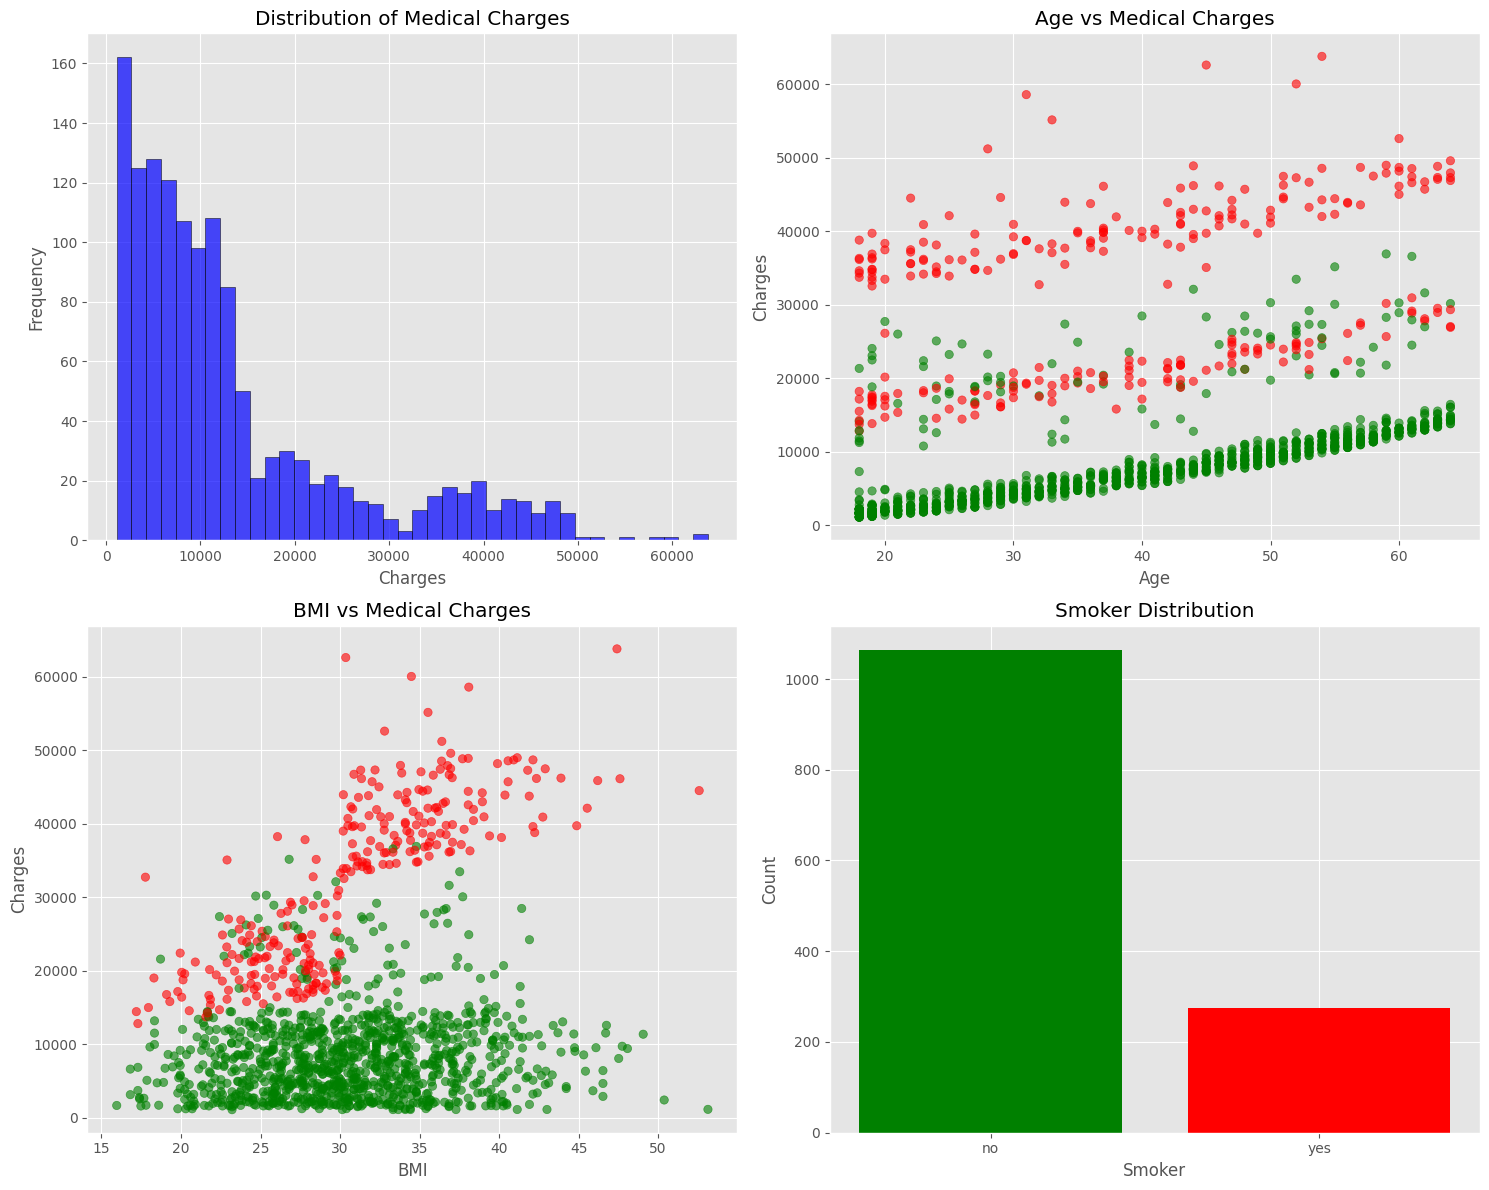

In [3]:
plt.style.use('ggplot')
plt.figure(figsize=(15, 12))

# Histogram of charges
plt.subplot(2, 2, 1)
plt.hist(data['charges'], bins=40, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Medical Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')

# Age vs Charges (colored by smoker)
plt.subplot(2, 2, 2)
colors = data['smoker'].map({'no': 'green', 'yes': 'red'})
plt.scatter(data['age'], data['charges'], c=colors, alpha=0.6)
plt.title('Age vs Medical Charges')
plt.xlabel('Age')
plt.ylabel('Charges')

# BMI vs Charges (colored by smoker)
plt.subplot(2, 2, 3)
plt.scatter(data['bmi'], data['charges'], c=colors, alpha=0.6)
plt.title('BMI vs Medical Charges')
plt.xlabel('BMI')
plt.ylabel('Charges')

# Smoker count bar plot
plt.subplot(2, 2, 4)
smoker_counts = data['smoker'].value_counts()
plt.bar(smoker_counts.index, smoker_counts.values, color=['green', 'red'])
plt.title('Smoker Distribution')
plt.xlabel('Smoker')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


## Data Preprocessing
We convert categorical variables into numeric format, normalize numerical features, and prepare the feature matrix X and target vector y. Normalization ensures features contribute equally to training.


In [4]:
def preprocess_data(df):
    df = df.copy()
    df['sex'] = df['sex'].map({'female': 0, 'male': 1}).astype(np.float64)
    df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1}).astype(np.float64)
    df = pd.get_dummies(df, columns=['region'], drop_first=True)
    numerical_cols = ['age', 'bmi', 'children']
    for col in numerical_cols:
        df[col] = ((df[col] - df[col].min()) /
                   (df[col].max() - df[col].min())).astype(np.float64)
    X = df.drop('charges', axis=1).values.astype(np.float64)
    y = df['charges'].values.reshape(-1, 1).astype(np.float64)
    X = np.hstack((np.ones((X.shape[0], 1), dtype=np.float64), X))
    return X, y

X, y = preprocess_data(data)

## Train-Test Split
We split the dataset manually to control the random state and to ensure reproducibility without using sklearn libraries, as per the problem constraints.


In [5]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_idx = int(len(indices) * (1 - test_size))
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (1070, 9)
Testing set shape: (268, 9)


#  Linear Regression Implementation
 This section implements the Linear Regression algorithm using gradient descent to minimize the mean squared error. All computations are done from scratch using only NumPy.


In [6]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iters = n_iterations
        self.weights = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros((n_features, 1), dtype=np.float64)
        for i in range(self.n_iters):
            y_pred = np.dot(X, self.weights)
            loss = (1 / (2 * n_samples)) * np.sum((y_pred - y) ** 2)
            self.loss_history.append(loss)
            dw = (1 / n_samples) * np.dot(X.T.astype(np.float64), (y_pred - y).astype(np.float64))
            self.weights = self.weights.astype(np.float64) - self.lr * dw.astype(np.float64)
            if i % 100 == 0:
                print(f"Iteration {i}: Loss = {loss:.2f}")

    def predict(self, X):
        return np.dot(X, self.weights)

    def r2_score(self, y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

    def mean_absolute_error(self, y_true, y_pred):
        return np.mean(np.abs(y_true - y_pred))

    def root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(np.mean((y_true - y_pred) ** 2))

## Model Training & Evaluation
 The model is trained and evaluated using R-squared, MAE, and RMSE metrics. These help assess how well our predictions match the actual charges.


In [7]:
print("\nTraining Linear Regression Model:")
model = LinearRegression(learning_rate=0.1, n_iterations=1000)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_r2 = model.r2_score(y_train, y_train_pred)
test_r2 = model.r2_score(y_test, y_test_pred)
mae = model.mean_absolute_error(y_test, y_test_pred)
rmse = model.root_mean_squared_error(y_test, y_test_pred)

print("\nModel Evaluation:")
print(f"Training R-squared: {train_r2:.4f}")
print(f"Testing R-squared: {test_r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

feature_names = ['bias', 'age', 'sex', 'bmi', 'children', 'smoker',
                 'region_northwest', 'region_southeast', 'region_southwest']
print("\nModel Coefficients:")
for name, coef in zip(feature_names, model.weights.flatten()):
    print(f"{name}: {coef:.4f}")


Training Linear Regression Model:
Iteration 0: Loss = 160709674.78
Iteration 100: Loss = 21712427.95
Iteration 200: Loss = 18969215.71
Iteration 300: Loss = 18473668.38
Iteration 400: Loss = 18275070.87
Iteration 500: Loss = 18166311.26
Iteration 600: Loss = 18099921.69
Iteration 700: Loss = 18057830.19
Iteration 800: Loss = 18030790.89
Iteration 900: Loss = 18013340.33

Model Evaluation:
Training R-squared: 0.7502
Testing R-squared: 0.7502
Mean Absolute Error (MAE): $4006.41
Root Mean Squared Error (RMSE): $6244.76

Model Coefficients:
bias: -1334.5498
age: 12032.0899
sex: -39.4762
bmi: 10840.4327
children: 2359.1671
smoker: 23590.1213
region_northwest: -402.2198
region_southeast: -1076.9468
region_southwest: -926.6950


## Visualization of Model Performance
We plot the loss curve, actual vs predicted values, residuals, and feature importance to better understand the model’s performance and interpretability.


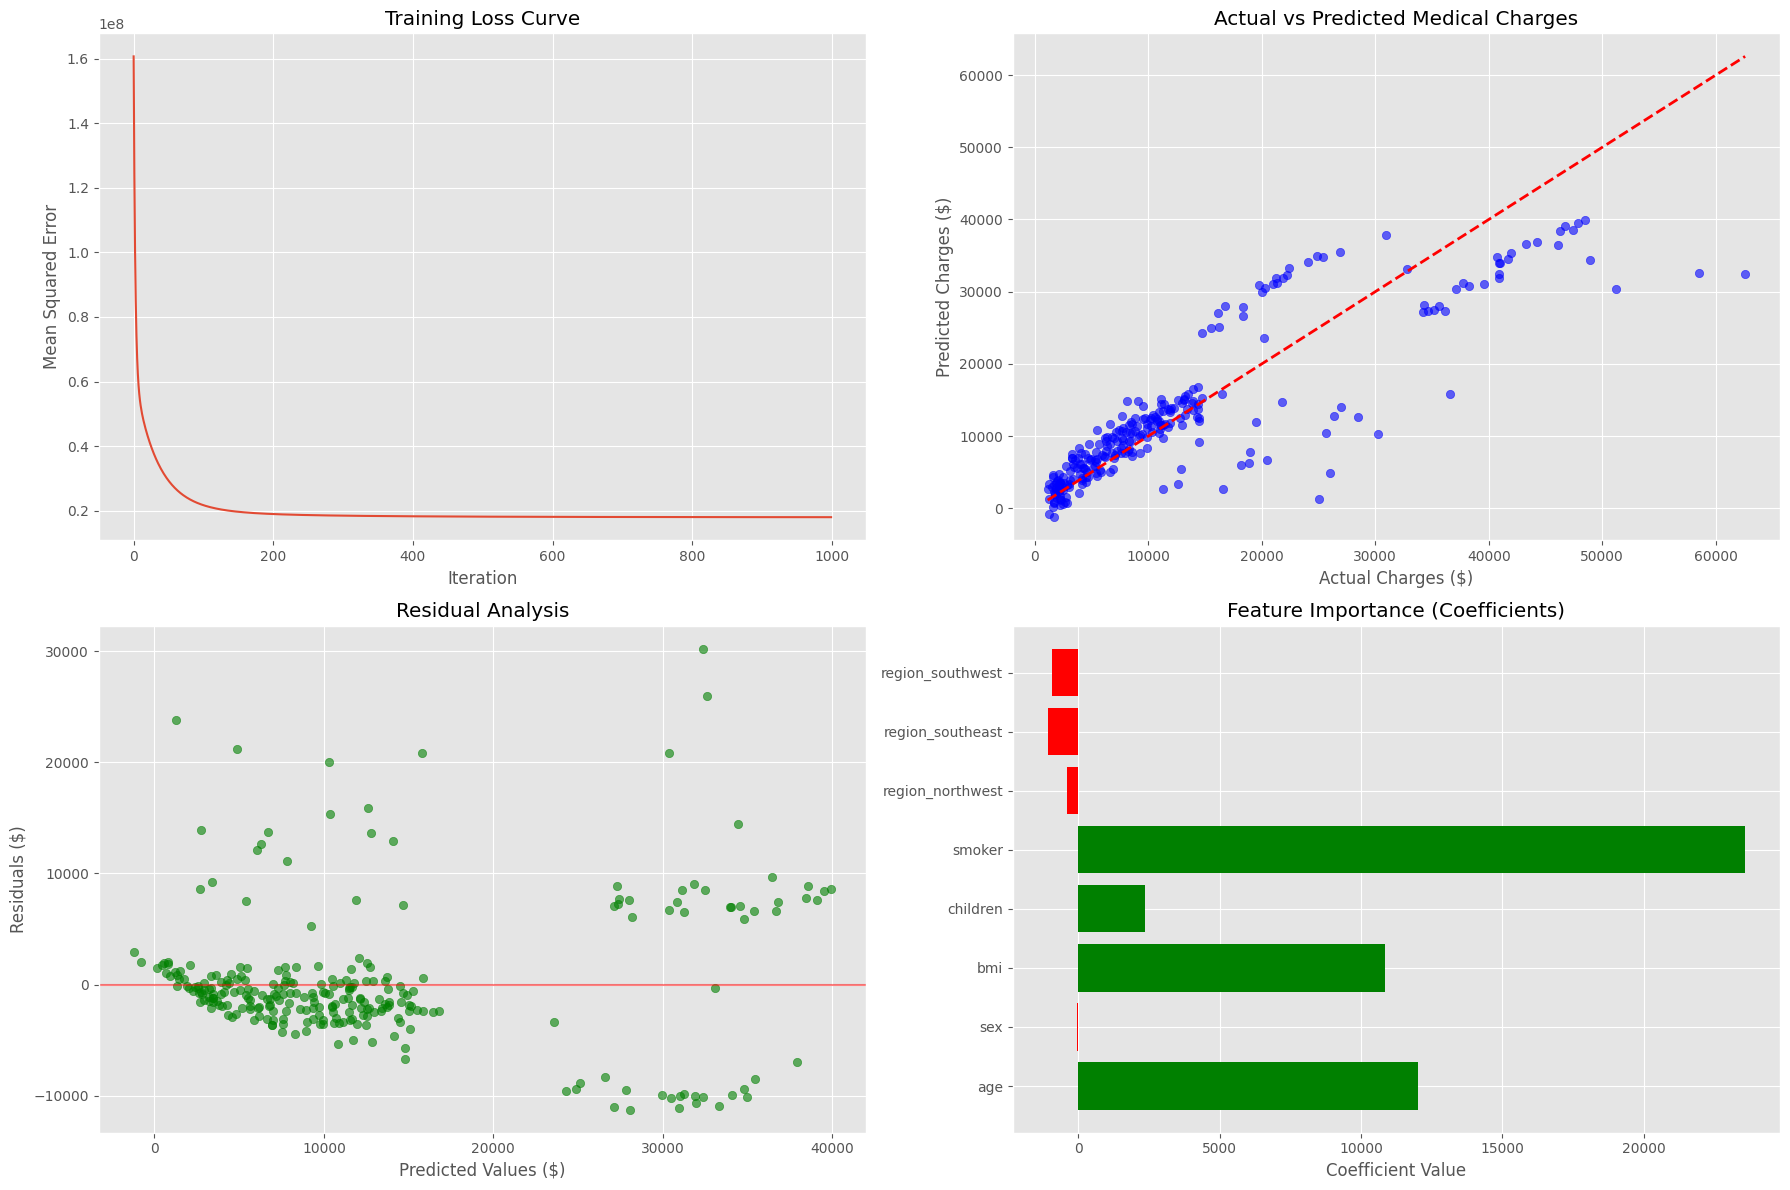


GitHub Link https://github.com/Aryan-Kanada/FSM.ML.2


In [8]:
plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
plt.plot(model.loss_history)
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Medical Charges')
plt.xlabel('Actual Charges ($)')
plt.ylabel('Predicted Charges ($)')
plt.grid(True)
plt.subplot(2, 2, 3)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.5)
plt.title('Residual Analysis')
plt.xlabel('Predicted Values ($)')
plt.ylabel('Residuals ($)')
plt.grid(True)
plt.subplot(2, 2, 4)
features = feature_names[1:]
coefs = model.weights.flatten()[1:]
colors = ['green' if c > 0 else 'red' for c in coefs]
plt.barh(features, coefs, color=colors)
plt.title('Feature Importance (Coefficients)')
plt.xlabel('Coefficient Value')
plt.grid(True)
plt.tight_layout()
plt.show()

GitHub = "https://github.com/Aryan-Kanada/FSM.ML.2"
print("\nGitHub Link",GitHub)


## Graph 1
A smooth, downward curve here means gradient descent optimization is successfully minimizing the error. This indicates your model is learning properly and the implementation is solid.

## Graph 2
-  Each point is one patient.
-  The red dashed line shows perfect predictions.
-  Points close to the line = accurate predictions.
- ️ Points far from the line = prediction error.

- The model performs well overall and captures key trends, though high-charge outliers show slight deviations.

## Graph 3

-  Residual = Actual - Predicted
-  Each point shows the error for a prediction.
-  The red horizontal line at 0 represents perfect predictions.

- A random scatter around the red line indicates a good fit.
- Systematic patterns would suggest model bias — but this plot shows no clear structure, which means our model's errors are well distributed.


